In [17]:
import pandas as pd
import io
from sklearn.preprocessing import normalize
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import spearmanr as corr 

In [3]:
# READING functions for files

# Read a normal text file
def read_text(filename=None):
    data = []
    with open(filename, "r") as fp:
        for eachLine in fp:
            data.append(eachLine.strip())
    return data
        
# Could not read the files using pandas dataframes directly (below). 
# Therefore, reading the data as normal text and then putting it into Dataframes later on.  
def read_file(filename=None, header=None, cols=[], delimiter=None):
    sep = " " if delimiter is None else delimiter
        
    if header is None:
        if cols is not []:
            assert isinstance(cols, list)
            #cols = map(str, cols)
        
        dataframe = pd.read_csv(filename, header=None, names=cols, sep=sep)
    else:
        dataframe = pd.read_csv(filename, sep=sep)
    return dataframe

# WRITING functions
def write_text(filename=None, data=None):
    with open(filename, "w") as fp:
        for eachLine in data:
            fp.write(eachLine.strip() + "\n")
            
# Make Dirs (even in a hierarchy)
def make_dirs(path=None):
    try:
        os.makedirs(path, exist_ok=False)
        print("Dataset dir created")
    except FileExistsError as e:
        print("Dataset directory already exists!")
    return


# In[95]:


# READ INPUT: CONSTITUENT DATA FILES
def get_constituent_data(constituent_list, constituent_vectors):
    # Read constituent list
    const_list = pd.DataFrame({'constituents':read_text(filename=constituent_list)})
    #print(const_list.info)

    # Read constituent vectors
    vectors = read_text(filename=constituent_vectors)
    c_list = []
    c_vectors = []
    for eachLine in vectors:
        parts = eachLine.split(" ")
        # First column is the constituent list 
        c_list.append(parts[0])
        # Second column onwards is the entire vector for the constituent
        c_vectors.append(parts[1:])
    const_vectors = pd.DataFrame({'constituents':c_list, 'vectors':c_vectors}) 
    print("Vector matrix shape: ", const_vectors['vectors'].shape, len(const_vectors['vectors'][0]) )

    # # SANITY CHECK
    # # 1. No. of constituents are the same and entries are on the same row
    assert (len(const_list["constituents"]) == len(const_vectors["constituents"]))
    print("Read constituents (%d) and vectors (%d):" % (len(const_list["constituents"]),len(const_vectors["constituents"])))

    row_check = [True if const_list["constituents"][i] == const_vectors["constituents"][i] else False for i in range(len(const_list["constituents"]))]
    for i in range(len(const_list['constituents'])):
        if not const_list["constituents"][i] == const_vectors["constituents"][i]:
            print(const_list["constituents"][i], const_vectors["constituents"][i])

    assert(all(row_check)), "Constituent List and Vector files do not match"
    print("Constituent labels and order in both files match")
    
    return const_list, const_vectors 


# In[96]:


# READ OUTPUT: COMPOUND DATA FILES
def get_compound_data(compound_list, compound_vectors):
    
    # Read compound list
    comp_list = pd.DataFrame({'compound':read_text(filename=compound_list)})
    #print(comp_list.info)

    # Read constituent vectors
    vectors = read_text(filename=compound_vectors)
    c_list = []
    c_vectors = []
    for eachLine in vectors:
        parts = eachLine.split(" ")
        # First column is the constituent list 
        c_list.append(parts[0])
        # Second column onwards is the entire vector 
        c_vectors.append(parts[1:])
    comp_vectors = pd.DataFrame({'compound':c_list, 'vectors':c_vectors}) 
    #print(comp_vectors.info)

    # # SANITY CHECK
    # # 1. No. of constituents are the same and entries are on the same row
    assert (len(comp_list["compound"]) == len(comp_vectors["compound"]))
    print("Read compounds (%d) and vectors (%d):" % (len(comp_list["compound"]),len(comp_vectors["compound"])))

    row_check = [True if comp_list["compound"][i] == comp_vectors["compound"][i] else False for i in range(len(comp_list["compound"]))]
    for i in range(len(comp_list['compound'])):
        if not comp_list["compound"][i] == comp_vectors["compound"][i]:
            print(comp_list["compound"][i], comp_vectors["compound"][i])

    assert(all(row_check)), "Compound List and Vector files do not match"
    print("Compound labels and order in both files match")
    
    return comp_list, comp_vectors


# In[97]:


# # NORMALIZING THE CONSTITUENT AND COMPOUND VECTORS 

def normalize_data(normalization, ct_vec=None, cp_vec=None):
    
    if normalization:
        if ct_vec is not None:
            ct_vec['vectors'] = normalize(ct_vec['vectors'].values.tolist(), norm="l2", axis=1).tolist()
            print("SELECTED :: Constituent Normalization = True")
            
        if cp_vec is not None:
            #print(comp_vectors['vectors'].head(1))
            cp_vec['vectors'] = normalize(cp_vec['vectors'].values.tolist(), norm="l2", axis=1).tolist()
            #print(comp_vectors['vectors'].head(1))
            print("SELECTED :: Compound Normalization = True")  
    else:
        
        print("SELECTED :: Normalization = False")
    
    return ct_vec, cp_vec


# In[98]:


def construct_vector(w1_vec, w2_vec, op=None):
    # Perform the required operation on the vectors
    if op == "concatenation":
        return np.concatenate((w1_vec, w2_vec), axis=None)
    if op == "addition":
        return np.add(w1_vec, w2_vec)
    if op == "multiplication":
        return np.multiply(w1_vec, w2_vec)
    
# The function below works to create both the TRAINING and TEST datasets. 
# The only difference between the two is that TEST dataset 'does not' have any OUTPUT values, so we skip those

def get_dataset(dataset_type, op=None, dataset=None, input_df=None, output_df=None):
    # Create a dataset from the CAOSS training dataset
    input_data = []
    output_data = []
    skipped_data = []
    datapoints = []
    skipped = False
    output_vec = []
    
    df_w1 = pd.DataFrame({'vec':[]})
    df_w2 = pd.DataFrame({'vec':[]})
    df_out = pd.DataFrame({'vec':[]})
    data_in_out = pd.DataFrame({'input':[], 'output':[]}) 
    
    for eachLine in dataset:
        skipped = False
        # Get the dataset elements, who's vectors have to be fetched from the dataframe 
        w1, w2, compound = eachLine.split(" ")
        # Get the vectors for input and output
        # NOTE: Some compound vectors were not present in the 'compound' files, 
                # so they had to be looked up into the constituent files. 
        # If there was an exception in fetching the vectors, the datapoint was skipped
        try:
            w1_vec = input_df['vectors'][input_df.index[input_df['constituents'] == w1]].tolist()
            w2_vec = input_df['vectors'][input_df.index[input_df['constituents'] == w2]].tolist()
            
            if not dataset_type == "test":
                output_vec = output_df['vectors'][output_df.index[output_df['compound'] == compound]].tolist()
                if len(output_vec) < 1:
                    output_vec = input_df['vectors'][input_df.index[input_df['constituents'] == compound]].tolist()

        except Exception as e:
            print("Error in fetching vectors for datapoint: %s" % (eachLine))
            skipped = True
            
        # If ANY input or output vector had LEN < 1 (i.e., could not be fetched), the datapoint was skipped!
        if (len(w1_vec) < 1 or len(w2_vec) < 1) or (len(output_vec) < 1 and not dataset_type == "test"):
            print("Skipping datapoint :: %s" % (eachLine))
            skipped = True
        
        if not skipped:
            w1_vec = np.asarray(w1_vec[0], dtype=np.float)
            w2_vec = np.asarray(w2_vec[0], dtype=np.float)
#             print(len(w1_vec), len(w2_vec))
            op_vec = construct_vector(w1_vec, w2_vec, op=op)
#             print("Input op vec:", len(op_vec))
            input_data.append(op_vec)
            datapoints.append(eachLine)
            if not dataset_type == "test":
                output_vec = np.asarray(output_vec[0], dtype=np.float)
#                 print("Output op vec:", len(output_vec))
                output_data.append(output_vec)
        else:
            skipped_data.append(eachLine)
            
    return input_data, output_data, skipped_data, datapoints


# In[99]:


# READING CAOSS TRAINING DATA 

def create_training_datasets(dataset_path, training_data_file, operation, process, normalization, const_vectors=None, comp_vectors=None):
    
    training_dataset = read_text(filename=training_data_file)

    # CREATING OUR Training DATASET
    for eachOperation in operation:
        print("TRAIN OPERATION :: ", eachOperation)
        # Get the input, output vectors AND the skipped and ACTUAL training datapoints
        input_data, output_data, skipped_data, datapoints = get_dataset("train", op=eachOperation, 
                                                                        dataset=training_dataset, 
                                                                        input_df=const_vectors, 
                                                                        output_df=comp_vectors)

        assert (len(input_data) == len(output_data)), "INPUT and OUTPUT data should be of the same length"
        print("\tTraining data extracted")
        print("\t", len(input_data), len(datapoints))
        print("\tInput vector dims:", len(input_data[0]))
        print("\tOutput vector dims:", len(output_data[0]))
    #     print(input_data[0])
    #     break

        try:
            final_training_data = ["\t".join([datapoints[i], ",".join(input_data[i]), ",".join(output_data[i])]) for i in range(len(input_data))]
        except TypeError as e:
            # TypeError: sequence item 0: expected str instance, float found
            # So, we explicitly TypeCast both input and output arrays as strings first!
            final_training_data = ["\t".join([datapoints[i], ",".join(map(str, input_data[i])), ",".join(map(str,output_data[i]))]) for i in range(len(input_data))]


        # final_traning_data CAN be also be shuffled and divided into traning + validation data at this point

        training_filename = "_".join([process, "TRAIN", operation[eachOperation]])
        if normalization:
            training_filename += "_L2Norm"
        else:
            training_filename += "_UnNorm" 
        training_filename += ".txt"


        write_text(filename=os.path.join(dataset_path, training_filename), data=final_training_data)
        if len(skipped_data) > 0:
            write_text(filename=os.path.join(dataset_path, "SKIPPED_"+process+"_caoss_TRAIN_data.txt"), data=skipped_data)
        print("Training data saved! : %s" % os.path.join(dataset_path, training_filename))
        
    return


# In[100]:


# READING the CAOSS TEST DATASET
def create_test_datasets(dataset_path, test_data_file, operation, process, normalization, const_vectors=None, comp_vectors=None):
    test_dataset = read_text(filename=test_data_file)

    # CREATING OUR TEST DATASET
    for eachOperation in operation:
        print("TEST OPERATION :: ", eachOperation)
        # Get the input, output vectors AND the skipped and ACTUAL test datapoints
        input_data, output_data, skipped_data, datapoints = get_dataset("test", op=eachOperation, 
                                                                        dataset=test_dataset, 
                                                                        input_df=const_vectors, 
                                                                        output_df=comp_vectors)

    #     assert (len(input_data) == len(output_data)), "INPUT (%d) and OUTPUT (%d) data should be of the same length" % (len(input_data), len(output_data))
        print("\tTest data extracted")
        print("\t", len(input_data), len(datapoints))
        print("\tInput vector dims:", len(input_data[0]))

        try:
            final_test_data = ["\t".join([datapoints[i], ",".join(input_data[i])]) for i in range(len(input_data))]
        except TypeError as e:
            # TypeError: sequence item 0: expected str instance, float found
            # So, we explicitly TypeCast both input and output arrays as strings first!
            final_test_data = ["\t".join([datapoints[i], ",".join(map(str, input_data[i]))]) for i in range(len(input_data))]


        # final_traning_data CAN be also be shuffled and divided into traning + validation data at this point

        test_filename = "_".join([process, "TEST", operation[eachOperation]])
        if normalization:
            test_filename += "_L2Norm"
        else:
            test_filename += "_UnNorm" 
        test_filename += ".txt"

        write_text(filename=os.path.join(dataset_path, test_filename), data=final_test_data)
        if len(skipped_data) > 0:
            write_text(filename=os.path.join(dataset_path, "SKIPPED_"+process+"_caoss_TEST_data.txt"), data=skipped_data)
        print("Test data saved! : %s" % os.path.join(dataset_path, test_filename))
    
    return


# In[105]:

def concatenate_multimodal_data(t_vectors, v_vectors, text, save_key):
    
    # print(text)
    intersect = np.intersect1d(t_vectors[text], v_vectors[text]).tolist()
    vectors = []
    t_vecs = []
    v_vecs = []
    for i in range(len(intersect)):
        term = intersect[i]
        t_vec = t_vectors['vectors'][t_vectors.index[t_vectors[text] == term]].tolist()
        v_vec = v_vectors['vectors'][v_vectors.index[v_vectors[text] == term]].tolist()
        vectors.append(t_vec[0] + v_vec[0])
        t_vecs.append(t_vec[0])
        v_vecs.append(v_vec[0])
        # print(len(t_vec[0]),len(v_vec[0]), len(vectors[i]))
    assert len(intersect) == len(t_vecs) == len(v_vecs)
    
    c_vectors = pd.DataFrame({save_key:intersect, 'text_vecs':t_vecs, 'vision_vecs':v_vecs})
    
    return c_vectors, intersect, t_vecs, v_vecs

In [4]:
# Give filenames and filepaths for TEXT or VISION

# Variables (Also used to give filenames dynamically)
processes = ['textvision']
normalizations = [False, True]

for process in processes:
    print("PROCESS :: ", process)

    if process == "textvision":
        print("Processing text vision data")

        t_constituent_list = "./data/__text_vectors/text_constituents.list.txt"
        t_constituent_vectors = "./data/__text_vectors/text_constituents.vectors.txt"
        t_compound_list = "./data/__text_vectors/text_noun-compounds.list.txt"
        t_compound_vectors = "./data//__text_vectors/text_noun-compounds.vectors.txt"
        
        t_const_list, t_const_vectors = get_constituent_data(t_constituent_list,t_constituent_vectors)
        t_comp_list, t_comp_vectors = get_compound_data(t_compound_list, t_compound_vectors)

        v_constituent_list = "./data/__vision_vectors/vision_constituents.list.txt"
        v_constituent_vectors = "./data/__vision_vectors/vision_constituents.vectors.txt"
        v_compound_list = "./data/__vision_vectors/vision_noun-compounds.list.txt"
        v_compound_vectors = "./data/__vision_vectors/vision_noun-compounds.vectors.txt"
        
        v_const_list, v_const_vectors = get_constituent_data(v_constituent_list,v_constituent_vectors)
        v_comp_list, v_comp_vectors = get_compound_data(v_compound_list, v_compound_vectors)

        const_vectors, ct_labels, ct_tvecs, ct_vvecs = concatenate_multimodal_data(t_const_vectors, v_const_vectors, 'constituents', 'word')
        comp_vectors, cp_labels, cp_tvecs, cp_vvecs = concatenate_multimodal_data(t_comp_vectors, v_comp_vectors, 'compound', 'word')
        
    else:

        print("NOTHING HERE")
    
    print("Total common Constituent vectors :: ",  len(const_vectors))
    print("Total common Compound vectors ::", len(comp_vectors))
    print("Total vectors ::", len(const_vectors) + len(comp_vectors))
    
    all_vecs = pd.concat([const_vectors, comp_vectors])
    labels = ct_labels + cp_labels
    tvecs = ct_tvecs + cp_tvecs
    vvecs = ct_vvecs + cp_vvecs
    
    print("*****************************")   

PROCESS ::  textvision
Processing text vision data
Vector matrix shape:  (2387,) 400
Read constituents (2387) and vectors (2387):
Constituent labels and order in both files match
Read compounds (5988) and vectors (5988):
Compound labels and order in both files match
Vector matrix shape:  (942,) 300
Read constituents (942) and vectors (942):
Constituent labels and order in both files match
Read compounds (578) and vectors (578):
Compound labels and order in both files match
Total common Constituent vectors ::  825
Total common Compound vectors :: 553
Total vectors :: 1378
*****************************


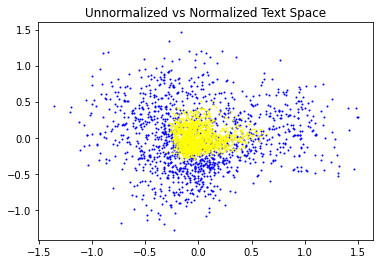

In [5]:
# PCA and plot 
# Text and vision -- unnormalized data
plt.clf()

tvecs_red = PCA(n_components=2).fit_transform(tvecs)
ttvecs_red = PCA(n_components=2).fit_transform(normalize(tvecs, norm="l2", axis=1))
vvecs_red = PCA(n_components=2).fit_transform(vvecs)

plt.scatter(tvecs_red[:, 0], tvecs_red[:, 1], color = 'blue', s=1)
plt.scatter(ttvecs_red[:, 0], ttvecs_red[:, 1], color = 'yellow', s=1)
plt.title("Unnormalized vs Normalized Text Space")
plt.show()


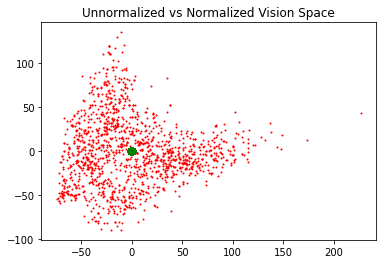

In [6]:
# PCA and plot 
# Text and vision -- unnormalized data

plt.clf()

tvecs_red = PCA(n_components=2).fit_transform(tvecs)
vvecs_red = PCA(n_components=2).fit_transform(vvecs)
vvvecs_red = PCA(n_components=2).fit_transform(normalize(vvecs, norm="l2", axis=1))

plt.scatter(vvecs_red[:, 0], vvecs_red[:, 1], color = 'red', s=1)
plt.scatter(vvvecs_red[:, 0], vvvecs_red[:, 1], color = 'green', s=40)
plt.title("Unnormalized vs Normalized Vision Space")
plt.show()

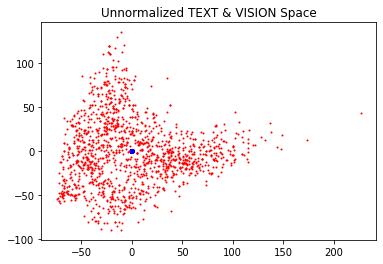

In [7]:
# PCA and plot 
# Text and vision -- unnormalized data

plt.clf()

tvecs_red = PCA(n_components=2).fit_transform(tvecs)
vvecs_red = PCA(n_components=2).fit_transform(vvecs)

plt.scatter(tvecs_red[:, 0], tvecs_red[:, 1], color = 'blue', s=1)
plt.scatter(vvecs_red[:, 0], vvecs_red[:, 1], color = 'red', s=1)
plt.title("Unnormalized TEXT & VISION Space")
plt.show()

In [8]:
# Inter space (Non-sensical)
tvcos = [dot(tvecs_red[i], vvecs_red[i])/(norm(tvecs_red[i])*norm(vvecs_red[i])) for i in range(len(tvecs_red))]

print("This number doesn't mean anything -- the dimensions accross spaces have NO correspondence")
print("BUT, its a good indicator for the 'actual' similarities later on")
print(np.mean(tvcos))


This number doesn't mean anything -- the dimensions accross spaces have NO correspondence
BUT, its a good indicator for the 'actual' similarities later on
-0.11261315780443379


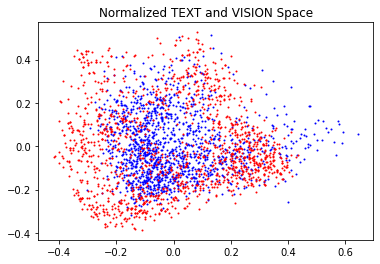

These are the 2 spaces that we are acutally interested in and, we'll use these later on for CCA


In [9]:
# PCA and plot
# Text and vision -- NORMALIZED  

plt.clf()

tvecs_red = PCA(n_components=2).fit_transform(normalize(tvecs, norm="l2", axis=1))
vvecs_red = PCA(n_components=2).fit_transform(normalize(vvecs, norm="l2", axis=1))

plt.scatter(tvecs_red[:, 0], tvecs_red[:, 1], color = 'blue', s=1)
plt.scatter(vvecs_red[:, 0], vvecs_red[:, 1], color = 'red', s=1)
plt.title("Normalized TEXT and VISION Space")
plt.show()
print("These are the 2 spaces that we are acutally interested in and, we'll use these later on for CCA")

In [10]:
# Inter space (Non-sensical)
tvcos = [dot(tvecs_red[i], vvecs_red[i])/(norm(tvecs_red[i])*norm(vvecs_red[i])) for i in range(len(tvecs_red))]
print(np.mean(tvcos))
print("Improved cosine similarity BUT still non-sensical")

0.049731730087780174
Improved cosine similarity BUT still non-sensical


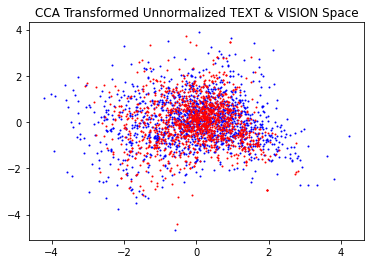

In [11]:
# CCA and plot 
# Text and vision -- unnormalized data

plt.clf()

tvecs_cca, vvecs_cca = CCA(n_components=2).fit_transform(tvecs, vvecs)

plt.scatter(tvecs_cca[:, 0], tvecs_cca[:, 1], color = 'blue', s=1)
plt.scatter(vvecs_cca[:, 0], vvecs_cca[:, 1], color = 'red', s=1)
plt.title("CCA Transformed Unnormalized TEXT & VISION Space")
plt.show()

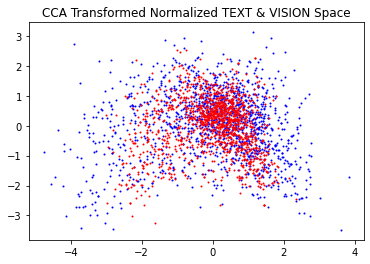

GOOD that Unnormalized vs normalized spaces (the above 2 plots) are not VERY different
because, covariances should be the same in the two spaces


In [12]:
# CCA and plot 
# Text and vision -- NORMALIZED

plt.clf()

tvecs_cca, vvecs_cca = CCA(n_components=2).fit_transform(normalize(tvecs, norm="l2", axis=1), normalize(vvecs, norm="l2", axis=1))

plt.scatter(tvecs_cca[:, 0], tvecs_cca[:, 1], color = 'blue', s=1)
plt.scatter(vvecs_cca[:, 0], vvecs_cca[:, 1], color = 'red', s=1)
plt.title("CCA Transformed Normalized TEXT & VISION Space")
plt.show()

print("GOOD that Unnormalized vs normalized spaces (the above 2 plots) are not VERY different")
print("because, covariances should be the same in the two spaces")

In [ ]:
def print_similarities(dim=None, normalization=None, max_iter=None, space1=None, space2=None):
    if not normalization: 
        space1_cca, space2_cca = CCA(n_components=dim, max_iter=max_iter).fit_transform(space1, space2)
    else:
        space1_cca, space2_cca = CCA(n_components=dim, max_iter=max_iter).fit_transform(normalize(space1, norm="l2", axis=1), normalize(space2, norm="l2", axis=1))
    
    s1s2cos = [dot(space1_cca[i], space2_cca[i])/(norm(space1_cca[i])*norm(space2_cca[i])) for i in range(len(space1_cca))]
#     print(np.mean(s1s2cos), np.median(s1s2cos), np.std(s1s2cos), dim, normalization, max_iter)
    
    return (np.median(s1s2cos), np.mean(s1s2cos), np.std(s1s2cos), dim, normalization, max_iter)


print("This particular block will take some time to compute, IF dims is a long list")
dims = [50,300]
max_iters = [500,1000,5000]
normalizations = [True, False]

sims = sorted([print_similarities(dim=dim, normalization=normalization, max_iter=max_iter, space1=tvecs, space2=vvecs) for dim in dims for max_iter in max_iters for normalization in normalizations], reverse=True)

print(sims)

print("These are the actual similarities that have been computed for 2 spaces")


In [13]:
# Intra space - cosine similarities 
tcos_sim = cosine_similarity(tvecs)
vcos_sim = cosine_similarity(vvecs)

print("The average cosine similarities of the ORIGINAL UNNORMALIZED TEXT and VISION spaces")
print(np.mean(tcos_sim), np.mean(vcos_sim))
# print(np.median(tcos_sim), np.median(vcos_sim))

The average cosine similarities of the ORIGINAL UNNORMALIZED TEXT and VISION spaces
0.097473024470814 0.666321643872867


In [14]:
# Intra space - cosine similarities 
tcos_sim = cosine_similarity(normalize(tvecs, norm="l2", axis=1))
vcos_sim = cosine_similarity(normalize(vvecs, norm="l2", axis=1))

print("The average cosine similarities of the ORIGINAL NORMALIZED TEXT and VISION spaces")
print(np.mean(tcos_sim), np.mean(vcos_sim))
# print(np.median(tcos_sim), np.median(vcos_sim))

print(" ")
print("ITs good that the similarity scores are almost indenticial for the unnormalized and normalized spaces")


The average cosine similarities of the ORIGINAL NORMALIZED TEXT and VISION spaces
0.09747302447081402 0.6663216438728671
 
ITs good that the similarity scores are almost indenticial for the unnormalized and normalized spaces


In [30]:
def print_similarities(dim=None, normalization=None, max_iter=None, space1=None, space2=None):
    print("computing CCA")
    if not normalization: 
        space1_cca, space2_cca = CCA(n_components=dim, max_iter=max_iter).fit_transform(space1, space2)
    
    else:
        space1_cca, space2_cca = CCA(n_components=dim, max_iter=max_iter).fit_transform(normalize(space1, norm="l2", axis=1), normalize(space2, norm="l2", axis=1))
    
    print("computing intra-space sims")
    tcos_sim = cosine_similarity(space1_cca)
    vcos_sim = cosine_similarity(space2_cca)
    
    otcos_sim = cosine_similarity(space1)
    ovcos_sim = cosine_similarity(space2)
    
    print("Text Matrix correlation:", corr(np.around(tcos_sim.flatten(), decimals=3), np.around(otcos_sim.flatten(), decimals=3)))
    print("Vision Matrix correlation:", corr(np.around(vcos_sim.flatten(), decimals=3), np.around(ovcos_sim.flatten(), decimals=3)))
    
    print("computing inter-space sims")
    space1 = PCA(n_components=300).fit_transform(space1)
    space2 = PCA(n_components=300).fit_transform(space2)
    os1s2cos = [dot(space1[i], space2[i])/(norm(space1[i])*norm(space2[i])) for i in range(len(space1))]
    s1s2cos = [dot(space1_cca[i], space2_cca[i])/(norm(space1_cca[i])*norm(space2_cca[i])) for i in range(len(space1_cca))]
    
    print("Inter-space correlation: ", corr(np.around(os1s2cos, decimals=3), np.around(s1s2cos, decimals=3)))
    
#     print(np.mean(tcos_sim), np.mean(vcos_sim))
#     print(np.median(tcos_sim), np.median(vcos_sim))

    return (np.median(s1s2cos), np.mean(s1s2cos), np.std(s1s2cos), dim, normalization, max_iter, np.mean(tcos_sim), np.mean(vcos_sim))

In [31]:
# print_similarities(dim=50, normalization=True, max_iter=500, space1=tvecs, space2=vvecs)

In [32]:
# Inter-space similarities, post CCA
dims = [50]
max_iters = [1000]
normalizations = [True, False]

print("Start")
sims = sorted([print_similarities(dim=dim, normalization=normalization, max_iter=max_iter, space1=tvecs, space2=vvecs) for dim in dims for max_iter in max_iters for normalization in normalizations], reverse=True)
print("END")

for eachSim in sims:
    print(eachSim)
    

Start
computing CCA
computing intra-space sims
Text Matrix correlation: SpearmanrResult(correlation=0.3314623568110125, pvalue=0.0)
Vision Matrix correlation: SpearmanrResult(correlation=0.1842336747455156, pvalue=0.0)
computing inter-space sims
Inter-space correlation:  SpearmanrResult(correlation=0.083088984296892, pvalue=0.002022412132936571)
computing CCA
computing intra-space sims
Text Matrix correlation: SpearmanrResult(correlation=0.3237176951712365, pvalue=0.0)
Vision Matrix correlation: SpearmanrResult(correlation=0.17889241310234363, pvalue=0.0)
computing inter-space sims
Inter-space correlation:  SpearmanrResult(correlation=0.07734385469857019, pvalue=0.004068354756949446)
END
(0.8390147965552441, 0.8282288362086534, 0.07366431368297294, 50, True, 1000, 0.00014857197603201022, 0.0003600175998597654)
(0.8263470336601949, 0.8020594462535744, 0.11401640663970537, 50, False, 1000, 0.0003918802856918176, 0.00043784019872703726)
